In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils.model_operations import *
from utils.image_operations import *

directory_path = os.getcwd()

In [2]:
def loadModelWeights(setName, percentage=1):
    """
    setname: either "train" or "test"
    
    returns dataframe with the weights of all models by layers
    """
    bias = ['0.02', '0.03', '0.04', '0.05']
    df = pd.DataFrame()
    modelId = 0
    for b in bias:
        if setName == "train":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/train')
        elif setName == "test":
            model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/test')
        else:
            raise "set name must either be train or test"
            
        for modelNumber in tqdm(range(len(model_data)//percentage), desc="loading model weights with bias "+b):
            model = model_data[modelNumber]
            layerNumber = 0
            for layer in model.layers:
                if len(layer.get_weights()) != 0:
                    # weights
                    weights = layer.get_weights()[0]
                    # biases
                    biases = layer.get_weights()[1]

                    df = df.append({'modelId':modelId,'weights':np.ravel(weights),'biases':np.ravel(biases),'layer':layerNumber, 'bias':b}, ignore_index=True)
                    layerNumber = layerNumber + 1
            modelId += 1       
    return df


In [3]:
trainModelWeights = loadModelWeights("train", percentage = 1)
testModelWeights = loadModelWeights("test",  percentage = 1)

loading model weights with bias 0.02:   0%|          | 0/2000 [00:00<?, ?it/s]2021-12-21 10:57:19.756498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
loading model weights with bias 0.05: 100%|██████████| 500/500 [01:30<00:00,  5.53it/s]


In [4]:
trainModelWeights

,modelId,weights,biases,layer,bias
0,0.0,"[-0.018486138, -0.03354981, -0.16535422, -0.06...","[-0.24564764, -0.081536554, -0.01958792, -0.11...",0.0,0.02
1,0.0,"[-0.26035, -0.031969644, 0.02034611, 0.0241116...","[-0.08751261, 0.14474091, -0.26124775, -0.2221...",1.0,0.02
2,0.0,"[-0.045246184, -0.022445709, -0.17450637, -0.0...","[0.18726698, -0.055855844, 0.10226409, -0.1979...",2.0,0.02
3,0.0,"[0.14023237, -0.0014608316, 0.17644557, 0.1682...","[-0.11819455, 0.109577455, -0.034734905, 0.126...",3.0,0.02
4,0.0,"[-0.25628987, 0.017059373, -0.14892107, 0.1850...","[0.04371279, 0.1927553, -0.0704351, 0.02792670...",4.0,0.02
...,...,...,...,...,...
39995,7999.0,"[-0.057432093, 0.012581817, 0.11414536, 0.0184...","[-0.0671344, -0.0277758, -0.0146967145, 0.0630...",0.0,0.05
39996,7999.0,"[-0.107280254, -0.09203529, -0.07334799, -0.10...","[-0.03721022, 0.040936325, -0.030625928, 0.002...",1.0,0.05
39997,7999.0,"[0.011979358, -0.034554373, -0.051180247, -0.0...","[0.010443132, -0.18427786, -0.066259846, -0.03...",2.0,0.05
39998,7999.0,"[-2.1241395, 0.58485734, -2.2942114, 0.4497387...","[3.359927, 1.6769673, 2.8587103, 2.1773515, 2....",3.0,0.05


In [5]:
from sklearn.decomposition import PCA

In [6]:
# Apply PCA 

def apply_PCA(trainModelWeights, testModelWeights, components=1000):

    pca_train_weights = []
    pca_test_weights = []

    for layer in range(5) :
        
        X_train = [x[0] for x in trainModelWeights[trainModelWeights['layer'] == 0][['weights']].values]
        X_test = [x[0] for x in testModelWeights[testModelWeights['layer'] == 0][['weights']].values]
        
        pca_train, pca_test = PCA(n_components = components), PCA(n_components = components)
        pca_train_weights.append(pca_train.fit_transform(X_train))
        pca_test_weights.append(pca_test.fit_transform(X_test))      

    return pca_train_weights, pca_test_weights

In [7]:
pca_train_weights, pca_test_weights = apply_PCA(trainModelWeights, testModelWeights)

In [8]:
def get_PCA_ModelWeights(ModelWeights, pca_model_weights) :
    PCA_ModelWeights = ModelWeights.copy()
    ordered_pca_weights = []

    for l0,l1,l2,l3,l4 in zip(pca_model_weights[0], pca_model_weights[1],pca_model_weights[2],pca_model_weights[3],pca_model_weights[4]) :
        ordered_pca_weights.append(l0)
        ordered_pca_weights.append(l1)
        ordered_pca_weights.append(l2)
        ordered_pca_weights.append(l3)
        ordered_pca_weights.append(l4)

    PCA_ModelWeights = PCA_ModelWeights.assign(pca_weights=ordered_pca_weights)

    return PCA_ModelWeights

In [9]:
PCA_trainModelWeights = get_PCA_ModelWeights(trainModelWeights, pca_train_weights)
PCA_trainModelWeights

,modelId,weights,biases,layer,bias,pca_weights
0,0.0,"[-0.018486138, -0.03354981, -0.16535422, -0.06...","[-0.24564764, -0.081536554, -0.01958792, -0.11...",0.0,0.02,"[0.27218338595085156, -0.23092936699232702, 0...."
1,0.0,"[-0.26035, -0.031969644, 0.02034611, 0.0241116...","[-0.08751261, 0.14474091, -0.26124775, -0.2221...",1.0,0.02,"[0.2721835207775092, -0.23092942237932645, 0.4..."
2,0.0,"[-0.045246184, -0.022445709, -0.17450637, -0.0...","[0.18726698, -0.055855844, 0.10226409, -0.1979...",2.0,0.02,"[0.27218353164205855, -0.2309295389616671, 0.4..."
3,0.0,"[0.14023237, -0.0014608316, 0.17644557, 0.1682...","[-0.11819455, 0.109577455, -0.034734905, 0.126...",3.0,0.02,"[0.27218357880894917, -0.23092942462262803, 0...."
4,0.0,"[-0.25628987, 0.017059373, -0.14892107, 0.1850...","[0.04371279, 0.1927553, -0.0704351, 0.02792670...",4.0,0.02,"[0.2721834439108311, -0.2309294317667347, 0.42..."
...,...,...,...,...,...,...
39995,7999.0,"[-0.057432093, 0.012581817, 0.11414536, 0.0184...","[-0.0671344, -0.0277758, -0.0146967145, 0.0630...",0.0,0.05,"[-0.35919388344761505, -0.19275044802463717, -..."
39996,7999.0,"[-0.107280254, -0.09203529, -0.07334799, -0.10...","[-0.03721022, 0.040936325, -0.030625928, 0.002...",1.0,0.05,"[-0.3591939800873321, -0.19275039739512664, -0..."
39997,7999.0,"[0.011979358, -0.034554373, -0.051180247, -0.0...","[0.010443132, -0.18427786, -0.066259846, -0.03...",2.0,0.05,"[-0.35919376156186106, -0.19275017446237078, -..."
39998,7999.0,"[-2.1241395, 0.58485734, -2.2942114, 0.4497387...","[3.359927, 1.6769673, 2.8587103, 2.1773515, 2....",3.0,0.05,"[-0.3591938465531692, -0.19275023074961442, -0..."


In [10]:
PCA_testModelWeights = get_PCA_ModelWeights(testModelWeights, pca_test_weights)
PCA_testModelWeights

,modelId,weights,biases,layer,bias,pca_weights
0,0.0,"[-0.1984677, 0.10607128, 0.02757767, 0.0406214...","[-0.00082488754, -0.16404912, -0.16673991, -0....",0.0,0.02,"[-0.23674860326346703, 0.07364349198241137, -0..."
1,0.0,"[0.06169182, 0.018116117, -0.078252785, -0.048...","[0.06270617, -0.033355515, -0.11744473, -0.136...",1.0,0.02,"[-0.2367486075147536, 0.07364348784942609, -0...."
2,0.0,"[0.09816912, 0.0027613225, -0.063564785, -0.11...","[-0.1339934, -0.12545621, -0.012984574, -0.121...",2.0,0.02,"[-0.23674859934792292, 0.07364349615562643, -0..."
3,0.0,"[0.29807323, -0.0807626, 0.045929182, 0.105066...","[0.10184695, 0.0049716868, 0.12874022, -0.0309...",3.0,0.02,"[-0.2367485972881196, 0.07364349192679322, -0...."
4,0.0,"[0.12900397, -0.062988736, 0.09713919, 0.02682...","[0.089443825, 0.16108993, -0.08055692, -0.0364...",4.0,0.02,"[-0.23674859483867847, 0.07364349996698968, -0..."
...,...,...,...,...,...,...
9995,1999.0,"[-0.0016367873, 0.14418039, 0.005059285, -0.03...","[0.082041904, 0.023735803, -0.07432411, -0.174...",0.0,0.05,"[-0.3308803270132464, 0.602044477663766, 0.110..."
9996,1999.0,"[0.041652713, 0.10205761, -0.04620276, -0.0346...","[-0.07159305, 0.053167004, 0.0056193713, -0.14...",1.0,0.05,"[-0.330880323035721, 0.6020444815122841, 0.110..."
9997,1999.0,"[0.21854231, 0.004612843, -0.030746, 0.0026039...","[-0.13545194, 0.031433977, 0.055850044, 0.0190...",2.0,0.05,"[-0.33088032561464514, 0.6020444811758117, 0.1..."
9998,1999.0,"[0.95756173, -0.75992316, -1.1382076, 0.616622...","[2.1560273, 0.8526798, 2.0636926, -0.86297965,...",3.0,0.05,"[-0.3308803539595303, 0.60204446760873, 0.1109..."


In [11]:
def dataset_iterator(ids, ModelWeights, feature, label):

    dataset = []
    labels = []

    for modelid in ids : 

        X = ModelWeights[ModelWeights['modelId'] == modelid][[feature]].values[:,0]
        if label == 'one' :
            y = float(ModelWeights[ModelWeights['modelId'] == modelid][['bias']].values[:,0][0])
        else : 
            y = [float(b) for b in ModelWeights[ModelWeights['modelId'] == modelid][['bias']].values[:,0]]

        layers = []
        for layer in X : 
            # nothing because testing PCA 
            # layer = np.random.choice(layer, size = 1000, replace = False) # random sampling
            # layer = np.pad(layer, pad_width=(0, 27648 - len(layer)))    # padding for Conv1d layer
            layers.append(layer)
        
        dataset.append(layers)
        labels.append(y)
    
    return dataset, labels
        

In [12]:
from sklearn.model_selection import train_test_split

def train_test(trainModelWeights, testModelWeights, feature='weights', label='one'):
    
    train_ids = list(range(0, int(trainModelWeights['modelId'].max() + 1)))
    test_ids = list(range(0, int(testModelWeights['modelId'].max() + 1)))
    train_ids, val_ids = train_test_split(train_ids, test_size = 0.2)
    

    train_dataset, train_labels = dataset_iterator(train_ids, trainModelWeights, feature, label)
    val_dataset, val_labels = dataset_iterator(val_ids, trainModelWeights, feature, label)
    test_dataset, test_labels = dataset_iterator(test_ids, testModelWeights, feature, label)
    
    return np.array(train_dataset), np.array(train_labels), train_ids, \
        np.array(val_dataset), np.array(val_labels), val_ids, \
        np.array(test_dataset),  np.array(test_labels), test_ids

In [8]:
# before feature extraction, shape of each layer : 
# 1 : 1800
# 2 : 10368 
# 3 : 27648
# 4 : 8192
# 5 : 1280

In [117]:
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, y_test, test_ids = train_test(PCA_trainModelWeights, PCA_testModelWeights, feature='pca_weights')

In [19]:
# X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, y_test, test_ids = train_test(trainModelWeights, testModelWeights, feature='weights')

In [132]:
"""
# test : 
from torch.nn.utils.rnn import pack_padded_sequence

# Could do that, but by considering that the batch size is the number of time-steps 
# but then i'm not sure that works with the LSTM layer ?

# torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)

# input can be of size T x B x * where T is the length of the longest sequence (equal to lengths[0]), 
# B is the batch size, and * is any number of dimensions (including 0). If batch_first is True, 
# B x T x * input is expected.

lengths = []
padded = []

for test in all_test : 

    test_lengths = [len(layer) for layer in test]
    test_max_len = max(test_lengths)
    test_padded = [np.pad(layer, (0,test_max_len - len(layer))) for layer in test]

    lengths.append(test_lengths)
    padded.append(test_padded)

padded = torch.Tensor(padded)
# input = torch.reshape(padded, (padded.size()[0], padded.size()[2], padded.size()[1]))
print(padded.size())
print(padded[0,:,:].size())
print(torch.Tensor(lengths)[0,:].size())
pack_padded_sequence(input = padded[0,:,:], lengths = torch.Tensor(lengths)[0,:], batch_first = True, enforce_sorted = False)

"""

"\n# test : \nfrom torch.nn.utils.rnn import pack_padded_sequence\n\n# Could do that, but by considering that the batch size is the number of time-steps \n# but then i'm not sure that works with the LSTM layer ?\n\n# torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)\n\n# input can be of size T x B x * where T is the length of the longest sequence (equal to lengths[0]), \n# B is the batch size, and * is any number of dimensions (including 0). If batch_first is True, \n# B x T x * input is expected.\n\nlengths = []\npadded = []\n\nfor test in all_test : \n\n    test_lengths = [len(layer) for layer in test]\n    test_max_len = max(test_lengths)\n    test_padded = [np.pad(layer, (0,test_max_len - len(layer))) for layer in test]\n\n    lengths.append(test_lengths)\n    padded.append(test_padded)\n\npadded = torch.Tensor(padded)\n# input = torch.reshape(padded, (padded.size()[0], padded.size()[2], padded.size()[1]))\nprint(padded.size())\nprint(p

In [118]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6400, 5, 1000), (6400,), (1600, 5, 1000), (1600,), (2000, 5, 1000), (2000,))

In [119]:
np.mean(X_train), np.mean(X_val), np.mean(X_test)

(-2.1909920118489135e-05, 8.763968047396391e-05, -5.516476164757478e-19)

In [120]:
np.std(X_train), np.std(X_val), np.std(X_test)

(0.14116045827140813, 0.1412076848407677, 0.14806209386862565)

In [15]:
def slicer(batch_size, num_rows, shuffle) :
    slices = []

    start = 0
    end = batch_size
    while end <= num_rows :
        slices.append((start,end))
        start = end
        end += batch_size
    
    if shuffle : 
        np.random.shuffle(slices)
    
    return slices

In [16]:
softmax_labels = {0.02 : [1,0,0,0], 0.03 : [0,1,0,0], 0.04 : [0,0,1,0], 0.05 : [0,0,0,1]}

In [17]:
# very basic iterator

def batcher(X_dataset, y_dataset, batch_size=8, shuffle=True):

    num_rows = X_dataset.shape[0]
    slices = slicer(batch_size, num_rows, shuffle)

    for (start, end) in slices : 
        batch = torch.Tensor(X_dataset[start:end, :, :])
        y_CE = []
        for y_label in y_dataset[start:end] : 
            y_CE.append(softmax_labels[y_label])
        #labels = torch.Tensor(y_dataset[start:end])
        labels = torch.Tensor(y_CE)
        yield (batch, labels)

In [89]:
# other resources to continue : 
# https://stackoverflow.com/questions/58251677/how-do-i-train-an-lstm-in-pytorch

class Model(nn.Module):
    # source : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM 
    
    def __init__(self):
        super(Model, self).__init__()
        
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # num_layers – Number of recurrent layers
        # batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)
        # bidirectional – If True, becomes a bidirectional LSTM, let's not get too complicated at first
        #self.conv1 = nn.Conv1d(27648, 1000, 1)
        #self.conv2 = nn.Conv1d(10000, 1000, 1)
        #self.conv3 = nn.Conv1d(1000, 100, 1)
        self.lstm1 = nn.LSTM(input_size = 1000, hidden_size = 100, num_layers = 1, batch_first = True, bidirectional = False)
        self.lstm2 = nn.LSTM(input_size = 100, hidden_size = 10, num_layers = 1, batch_first = True, bidirectional = False)
        self.dense = nn.Linear(10, 4)
        self.sm = nn.Softmax(dim = 2)

    def forward(self, x):
        # input : (N, L, H_in) 
        # where N = batch size
        #       L = sequence length
        #       H_in = input size
        # -> (batch_size, 5, num_features)
        
        # some conv1 layer to reduce the number of features

        #x = torch.reshape(x, (x.size()[0], x.size()[2], x.size()[1]))
        #x = self.conv1(x)
        #x = self.conv2(x)
        #x = self.conv3(x)
        #x = torch.reshape(x, (x.size()[0], x.size()[2], x.size()[1]))
        
        x, _ = self.lstm1(x)
        #print(x.shape)
        x, (hidden, cell) = self.lstm2(x)
        # hidden : final hidden state for each element in the batch, shape (1, 8, 10) -> reshape into (8,1,10)
        hidden = torch.reshape(hidden, shape = (hidden.size()[1], hidden.size()[0], hidden.size()[2]))
        #print(x.size())
        x = self.dense(hidden)
        #print(x.size())
        # x = self.sm(x)
        #print(x.size())
        
        return torch.reshape(x, shape = (x.size()[0],x.size()[2]))


# input size : (batch_size, 5, num_features) - for the 5 layers, and the features extracted
# output size : (batch_size, 1, 1) - for the prediction per model


model = Model()
# y = model(list(batcher(X_train, y_train))[0][0])

In [19]:
"""
categories = {0.02 : 0, 0.03 : 1, 0.04 : 2, 0.05 : 3}

def make_categorical(values):
    biases = torch.Tensor([0.02, 0.03, 0.04, 0.05])
    res = []
    for val in values : 
        idx = torch.argmin(torch.abs(biases - val))
        new_val = round(biases[idx].item(), 2)
        cat = categories[new_val]
        res.append(cat)
    return res
"""

In [121]:
from torch import optim
from torch.nn import MSELoss, CrossEntropyLoss
from sklearn.metrics import accuracy_score

criterion = CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = 0.01)


BATCH_SIZE = 16
NUM_EPOCHS = 50


losses = []
accuracy = []

val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    epoch_loss = []
    epoch_accuracies = []

    epoch_val_loss = []
    epoch_val_accuracies = []

    for data in batcher(X_train, y_train, batch_size = BATCH_SIZE) :
        
        # pass through model
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # backprop
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        epoch_loss.append(loss.item())

        # get training accuracy
        #cat_preds = make_categorical(outputs)
        #cat_labels = make_categorical(labels)
        #epoch_accuracies.append(accuracy_score(cat_labels, cat_preds))
        y_true = [lab.argmax() for lab in labels]
        y_pred = [pred.argmax() for pred in outputs]
        epoch_accuracies.append(accuracy_score(y_true, y_pred))

    losses.append(np.mean(epoch_loss))
    accuracy.append(np.mean(epoch_accuracies))


    # Validation accuracies and losses
    for data in batcher(X_val, y_val, batch_size=y_val.shape[0]) :
        inputs, labels = data
        outputs = model(inputs)

        # test loss
        loss = criterion(outputs, labels)
        epoch_val_loss.append(loss.item())

        # test accuracy
        #cat_preds = make_categorical(outputs)
        #cat_labels = make_categorical(labels)
        #epoch_val_accuracies.append(accuracy_score(cat_labels, cat_preds))
        y_true = [lab.argmax() for lab in labels]
        y_pred = [pred.argmax() for pred in outputs]
        epoch_val_accuracies.append(accuracy_score(y_true, y_pred))
    
    val_losses.append(np.mean(epoch_val_loss))
    val_accuracy.append(np.mean(epoch_val_accuracies))



100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


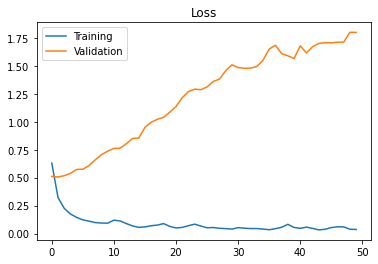

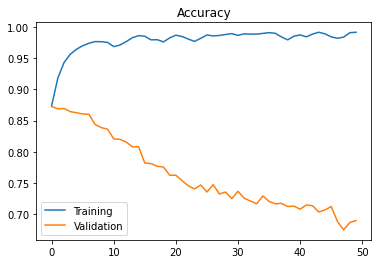

In [122]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses, label = 'Training')
plt.plot(list(range(len(losses))), val_losses, label = 'Validation')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(list(range(len(accuracy))), accuracy, label = 'Training')
plt.plot(list(range(len(accuracy))), val_accuracy, label = 'Validation')
plt.title('Accuracy')
plt.legend()
plt.show()

In [123]:
# test accuracy : 

for data in batcher(X_test, y_test, batch_size=y_test.shape[0]) :
    inputs, labels = data
    outputs = model(inputs)

    # test loss
    loss = criterion(outputs, labels)

    # test accuracy
    y_true = [lab.argmax() for lab in labels]
    y_pred = [pred.argmax() for pred in outputs]
    test_accuracy = accuracy_score(y_true, y_pred)
    
    #cat_preds = make_categorical(outputs)
    #cat_labels = make_categorical(labels)
    #accuracy = accuracy_score(cat_labels, cat_preds)

print('Test loss : ', loss.item())
print('Test accuracy : ', test_accuracy)

Test loss :  5.5508646965026855
Test accuracy :  0.2455
